# 10.2 Gated Recurrent Units (GRU)

As RNNs and particularly the LSTM architecture (Section 10.1) rapidly gained popularity during the 2010s, a number of researchers began to experiment with simplified architectures in hopes of retaining the key idea of incorporating an internal state and multiplicative gating mechanisms but with the aim of speeding up computation. The gated recurrent unit (GRU) (Cho et al., 2014) offered a streamlined version of the LSTM memory cell that often achieves comparable performance but with the advantage of being faster to compute (Chung et al., 2014).

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 10.2.1 Reset Gate and Update Gate

Here, the LSTM's three gates are replaced by two: the 'reset gate' and the 'update gate'. Intuitively, the reset gate controls how much of the previous state we might still want to remember. Likewise, an update gate would allow us to control how much of the new state is just a copy of the old one. The below figure illustrates the inputs for both the reset and update gates in a GRU, given the input of the current time step and the hidden state of the previous time step.

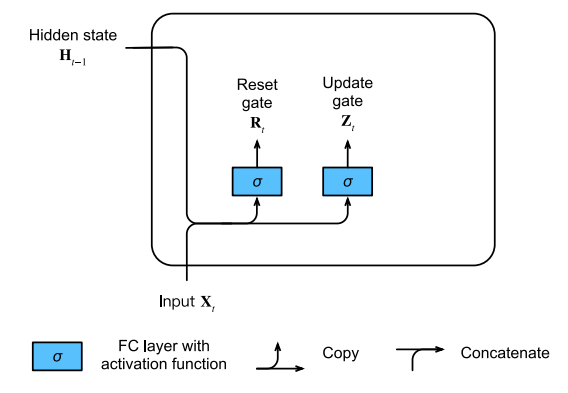

## 10.2.2 Candidate Hidden State

We compute "candidate hidden state" as follow:

$$
\tilde{\mathbf{H}}_t = tanh(\mathbf{X}_t \mathbf{W}_{xh} + (\mathbf{R}_t \odot \mathbf{H}_{t-1} ) \mathbf{W}_{hh} + \mathbf{b}_h)
$$

This represents the summarization of the current state.

"reset" means resetting the previous memory and saving current memory.

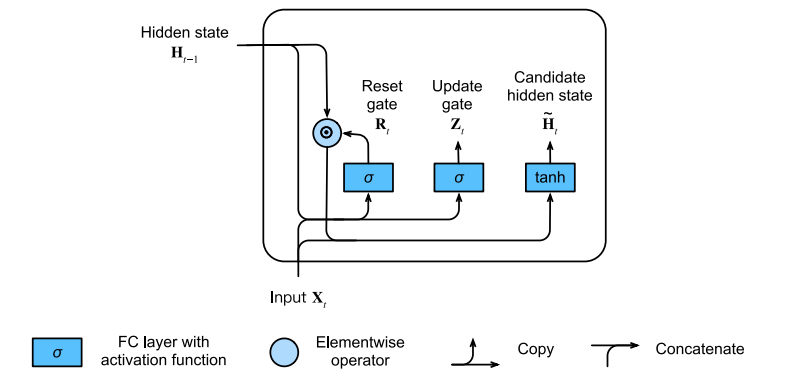

## 10.2.3 Hidden State

The below figure shows the computational flow of GRU after the final calculation.

Update means, updating final hidden state taking account candidate hidden state (current state) and previous hidden state.

In summary, 

 - Reset gates help capture short-term dependencies in sequences
 - Update gates help capture long-term dependencies in sequences

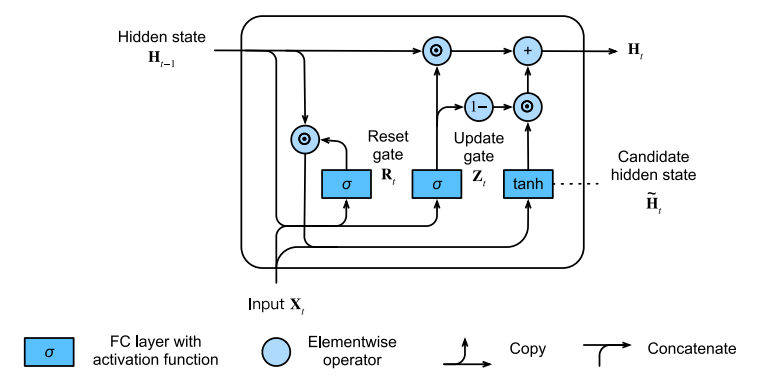

## 10.2.4 Implementation from Scratch

In [2]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
        init_weight(num_hiddens, num_hiddens),
        nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple() # Update gate
        self.W_xr, self.W_hr, self.b_r = triple() # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple() # Candidate hidden state


@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
        device=inputs.device)
        outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

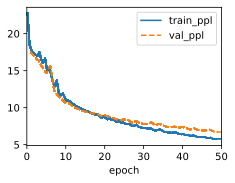

In [3]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.2.5 Concise Implementation

In [4]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

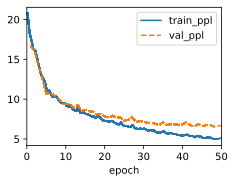

In [5]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [6]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the time traveller '